# Policy Gradients with PyTorch

In this notebook, I'm going to walk through an implementation of policy gradients in PyTorch. Policy gradient methods are a set of deep reinforcement learning algorithms that use neural networks to appoximate the policy function, which actions to take given a state. I was inspired to write this by the impressive results of [OpenAI Five](https://blog.openai.com/openai-five/), a team of agents that learned to play Dota 2 better than amateurs using policy gradients. OpenAI Five uses a variation of policy gradients called Proximal Policy Optimization (PPO) to train the agents. Deep reinforcement learning agents are notoriously unstable and difficult to train, but PPO seems to be the most reliable method currently available. So, this notebook is working out a basic policy gradient implementation, then future notebooks will implement a full-blown PPO agent.


I'll be using the CartPole environment from OpenAI Gym for this. The goal here is to move the cart left and right in an attempt to keep the pole upright.

<img src='assets/cartpole.gif' width=320px loop>

At this point, the CartPole environment seems to be the baseline for deep RL agents. If your agent can't solve CartPole, it can't solve anything.

If you are new to reinforcement learning, here are a couple great resources from [Andrej Karpathy](http://karpathy.github.io/2016/05/31/rl/) and [Arthur Juliani](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0).

First off, import gym and PyTorch (as well as staples Numpy and Matplotlib).

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

Creating an environment with Gym is simple, just `env = gym.make('env-name')`. I can get the CartPole environment with `'CartPole-v0'`. You can easily use other environments such as `'LunarLander-v2'` here and modify the code below appropriately.

In [18]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In the CartPole environment, there are 4 values describing the state: the pole's angle, the pole's angular velocity, the cart's position, and the cart's velocity. This is called the *state space*, these four values are sufficient to describe the environment for our agent.

The cart can make two actions, either move to the left or to the right. This is called the *action space*, the possible actions the agent can take in the environment. Here, the action space is *discrete*. That is, the actions can take on only specific values (move left or move right). The state space on the other hand is *continuous*, the values can be any numbers within some ranges. The actions here could be continuous. Instead of just "move left" or "move right" the actions could set the acceleration to the left or the acceleration to the right. In another notebook, I'll modify this implementation to work with continuous action spaces.

In [19]:
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")

State space: Box(4,)
Action space: Discrete(2)


What we want to do is find a *policy* that looks at the current state and makes a prediction about which action to take. This can be thought of as a function that takes the state as an input and returns a probability distribution for the actions. Mathematically, this is represented by $p\left(y_i \mid x_i\right)$ where $x_i$ is the state and $y_i$ is the action for some trial $i$.

<img src='assets/policy.svg'>

In the example shown above, we have a state $x_i$ and our policy tells us the probabilities to take our two actions, 0.8 for action 1 and 0.2 for action 2. Based on those probabilities, the agent will choose an action stochastically. That is, the action will be chosen randomly according to the probabilities from our policy: there is an 80% chance the agent will perform action 1 and a 20% chance the agent will perform action 2.

The goal here is to find a policy where our agent performs the task as well as possible. Neural networks with non-linear activation functions have a nice feature where they approximate arbitrary functions. This means we can train a neural network to give us our policy function $p\left(y_i \mid x_i\right)$. The goal is to give our network a state, $x_i$, and have it return a vector of probabilities for the action.  

The network will have a number of inputs equal to the dimension of the state space and a number of outputs equal to the dimensions of the action space. To add in non-linearity, I'll use a single hidden layer with a ReLU activation. The network might perform better with more layers and more units, feel free to modify this code and experiment with the network architecture.

We can train this network by turning our reinforcement learning problem into a supervised learning problem, discussed in the next section.

In [8]:
# Creating a class for the agent
class Agent:
    def __init__(self, n_states, n_hidden, n_actions, lr=0.003):
        
        # Define the agent's network
        self.net = nn.Sequential(nn.Linear(n_states, n_hidden),
                                 nn.ReLU(),
                                 nn.Linear(n_hidden, n_actions),
                                 nn.Softmax(dim=0))
        
        # How we're optimizing the network
        self.opt = optim.Adam(self.net.parameters(), lr=lr)
        
    def predict(self, observation):
        """ Given an observation, a state, return a probability distribution
            of actions
        """
        state = torch.tensor(observation, dtype=torch.float32)
        actions = agent.net(state)
        
        return actions

    def update(self, loss):
        """ Update the agent's network given a loss """
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

Since actions lead to later possible rewards, we want to propagate those rewards back to earlier actions. Good actions early on should be weighted more than later actions since they contribute more to the overall sequence of actions. 

TODO: Will need a better description here with some diagrams

In [9]:
def discount_rewards(rewards, gamma=0.99):
    discounted = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        discounted.insert(0, R)
        
    # Now normalize
    discounted = np.array(discounted)
    normed = (discounted - discounted.mean())/discounted.std()
    
    return normed

TODO: Describe training procedure here

In [ ]:
agent = Agent(4, 128, 2, lr=0.003)
total_episodes = 5000
max_steps = 999
solved_reward = 195

print_every = 10
update_every = 5
replay = {'actions':[], 'rewards':[]}
render = True
reward_log = []

ii = 0
while ii < total_episodes:
    state = env.reset()
    rewards, actions = [], []
    for t in range(max_steps):
        # Have our agent predict an action from the state
        action_ps = agent.predict(state)
        action = torch.multinomial(action_ps, 1).item()
        actions.append(action_ps[action].unsqueeze(0))
        
        # Using this action, get the next state and the reward
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        if render and ii % print_every == 0:
            env.render()
            
        if done or t == (max_steps - 1):
            # Record experiences
            reward_log.append(sum(rewards))
            if ii % print_every == 0:
                print(sum(rewards))
            
            losses = []
            rewards = discount_rewards(rewards)
            
            replay['actions'].extend(actions)
            replay['rewards'].extend(rewards)
            
            # Update our agent with the experiences
            if ii % update_every == 0:
                for a, r in zip(*replay.values()):
                    losses.append(-torch.log(a)*r)
                loss = torch.cat(losses).sum()
                agent.update(loss)
                
                replay['actions'], replay['rewards'] = [], []
            
            break
            
    if sum(reward_log[-100:])/100 > solved_reward:
        print(f"Environment solved in {ii-100} episodes with a reward of {np.mean(reward_log[-100:])}")
        break
        
    state = env.reset()
    ii += 1

**Note:** This plot of the rewards is for the Lunar Lander environment

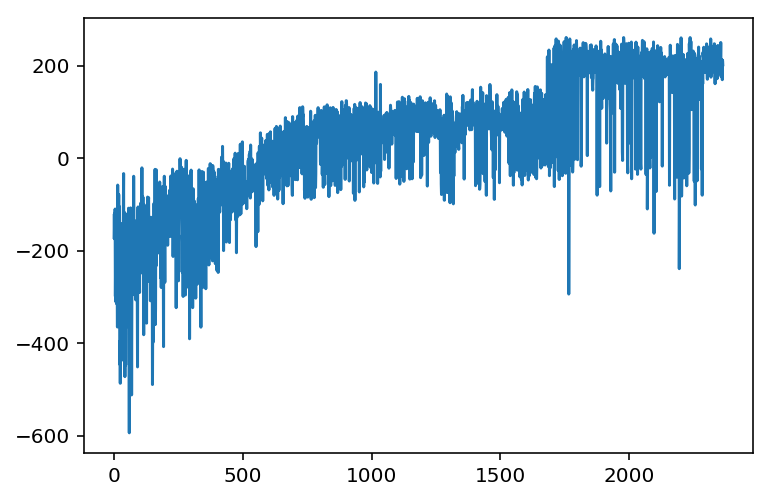

In [14]:
plt.plot(reward_log)

Here I'm just going to have our trained agent land a few times so I can make a video/gif.

In [16]:
trials = 10
max_steps = 999

for ii in range(trials):
    state = env.reset()
    # Have our agent predict an action from the state
    for ii in range(max_steps):
        action_ps = agent.predict(state)
        action = torch.multinomial(action_ps, 1).item()

        # Get the next state and the reward
        state, reward, done, _ = env.step(action)
        env.render()

        if done:
            break